# Loading data

In [1]:
import pickle

with open("../dataset/fixs.pkl", "rb") as f:
    fixs = pickle.load(f)

print(len(fixs), len(fixs[0]), len(fixs[0][0]), len(fixs[0][0][0]))
# n_sbj x n_img x n_fix x n_coord x 2

8 200 5 161


# Encoder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
from torch.utils.data import DataLoader

In [3]:
from torch.nn.utils.rnn import pack_padded_sequence

# Encoder: mappa le coordinate delle fissazioni nello spazio latente
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.project = nn.Linear(hidden_size, latent_size)
    
    def forward(self, batch, lengths):
        """
        batch: [B, T, 2] - Batches of fixations (Batch size, Sequence length, 2 coordinates)
        lengths: [B] - Lengths of each fixation in the batch
        """
        packed = pack_padded_sequence(batch, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, last_hidden_states = self.gru(packed)
        # packed_out: [B, T, H] - Output of the GRU for each time step, not used here
        # last_hidden_states: [1, B, H] - Last hidden state for each fixation in the batch
        last_hidden_states = last_hidden_states.squeeze(0)  # [1, B, H] -> [B, H]
        latent_states = self.project(last_hidden_states)  # [B, latent_size]
        return latent_states

# SDE

In [4]:
class LatentSDE(torchsde.SDEIto):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__(noise_type="diagonal")

        self.encoder = Encoder(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, input_size)
        )

        self.drift_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size)
        )

        self.diffusion_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size)
        )
    
    def f(self, t, y):
        return self.drift_net(y)
    
    def g(self, t, y):
        return self.diffusion_net(y)
    
    def encode(self, batch, mask):
        """
        batch: [B, T, 2] - Batches of fixations (Batch size, Sequence length, 2 coordinates)
        lengths: [B] - Lengths of each fixation in the batch
        """

        lengths = mask.sum(dim=1).long() # Fixations lengths

        return self.encoder(batch, lengths)
    
    def generate_fixation(self, z0, length):
        """
        Genera una sequenza di coordinate a partire da uno stato latente iniziale.
        
        Args:
            z0 (torch.Tensor): Stato latente iniziale, shape [1, latent_size].
            length (int): Numero di passi temporali da simulare.
            t0 (float): Tempo iniziale.
            t1 (float): Tempo finale.
            device (str): 'cpu' o 'cuda'.
        
        Returns:
            torch.Tensor: Sequenza generata di coordinate, shape [length, 2].
        """
        ts = torch.linspace(0, 1, length, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        zs = torchsde.sdeint(self, z0, ts)  # [length, 1, latent_size]
        decoded = self.decoder(zs)  # [length, 1, 2]
        return decoded.squeeze(1)  # [length, 2]
    
    def forward(self, batch, mask):
        """
        batch: [B, T, 2] - Batches of fixations (Batch size, Sequence length, 2 coordinates)
        lengths: [B] - Lengths of each fixation in the batch
        """
        ts = torch.linspace(0, 1, batch.size(1), device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')) # [T] - Time steps for the SDE

        lengths = mask.sum(dim=1).long() # Fixations lengths
        latent_states = self.encoder(batch, lengths) # [B, latent_size] - z0

        zs = torchsde.sdeint(self, latent_states, ts) # [T, B, latent_size]
        zs = zs.permute(1, 0, 2) # [B, T, latent_size]

        recon_x = self.decoder(zs) # [B, T, input_size]

        return recon_x

# DataLoader

In [5]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    lengths = torch.tensor([seq.shape[0] for seq in batch])
    # Padding the sequences to the maximum length in the batch
    padded = pad_sequence(batch, batch_first=True) # [B, T, 2]
    mask = torch.arange(padded.shape[1]).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.float()  # Convert to float for compatibility with loss functions
    return padded, mask

In [6]:
import random

def create_dataloaders(sbj_fixs, batch_size):
    random.shuffle(sbj_fixs)
    
    # 70% training, 15% validation, 15% test
    train_size = int(0.7 * len(sbj_fixs))
    val_size = int(0.15 * len(sbj_fixs))
    train_set = [torch.tensor(fix, dtype=torch.float) for img in sbj_fixs[:train_size] for fix in img]
    val_set = [torch.tensor(fix, dtype=torch.float) for img in sbj_fixs[train_size:train_size + val_size] for fix in img]
    test_set = [torch.tensor(fix, dtype=torch.float) for img in sbj_fixs[train_size + val_size:] for fix in img]

    # DataLoader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader

# Parameters

In [7]:
latent_size = 8 # Dimensionalità dello spazio latente
input_size = 2 # Coppie di coordinate
hidden_size = 128 # Dimensione dello stato nascosto
batch_size = 16 # Dimensione del batch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 200
log_every = 10
lr = 1e-3

criterion = nn.MSELoss()

# Main

In [8]:
import random
import matplotlib.pyplot as plt
import tqdm.notebook
import os

os.makedirs("sdes", exist_ok=True)
os.makedirs("losses", exist_ok=True)
os.makedirs("test_loaders", exist_ok=True)

from_sbj = 0 # Starting subject index
subject_bar = tqdm.notebook.tqdm(range(8), desc="Subjects", leave=True, position=0)
for i in subject_bar:
    if i < from_sbj:
        continue
    # Imposta il seed per la riproducibilità
    #random.seed(i)
    #torch.manual_seed(i)

    #print("Training subject " + str(i) + "...")
    sbj_fixs = fixs[i]
    
    sde = LatentSDE(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size).to(device)
    optimizer = optim.Adam(list(sde.parameters()), lr=lr)

    train_loader, val_loader, test_loader = create_dataloaders(sbj_fixs, batch_size)

    with open(f"test_loaders/test_loader_{i}.pkl", "wb") as f:
        pickle.dump(test_loader, f)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0

    sde.train()

    epoch_bar = tqdm.notebook.tqdm(range(num_epochs), desc="Epochs", leave=False, position=1)
    for epoch in epoch_bar:

        # Training
        epoch_train_loss = 0.0
        train_bar = tqdm.notebook.tqdm(train_loader, desc="Batches", leave=False, position=2)
        for batch, mask in train_bar:
            batch = batch.to(device)
            mask = mask.to(device)

            recon_x = sde(batch, mask)  # [B, T, latent_size]

            batch_loss = criterion(recon_x * mask.unsqueeze(-1), batch * mask.unsqueeze(-1)) # Mask to ignore padded values
            train_bar.set_postfix({"Batch Loss": batch_loss.item()})

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            epoch_train_loss += batch_loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation
        sde.eval() # Set the model to evaluation mode
        epoch_val_loss = 0.0
        with torch.no_grad():
            val_bar = tqdm.notebook.tqdm(val_loader, desc="Batches", leave=False, position=3)
            for batch, mask in val_bar:
                batch = batch.to(device)
                mask = mask.to(device)
                
                recon_x = sde(batch, mask)  # [B, T, latent_size]
                
                batch_loss = criterion(recon_x * mask.unsqueeze(-1), batch * mask.unsqueeze(-1)) # Mask to ignore padded values
                val_bar.set_postfix({"Batch Loss": batch_loss.item()})

                epoch_val_loss += batch_loss.item()

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        sde.train()

        epoch_bar.set_postfix({"Epoch Train Loss": epoch_train_loss, "Epoch Val Loss": epoch_val_loss})

        # Logging
        #if epoch % log_every == 0:
            #tqdm.notebook.tqdm.write(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Saving the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss            
            best_epoch = epoch
            subject_bar.set_postfix({"Best Epoch": best_epoch, "Best Val Loss": best_val_loss})
            torch.save({
                'sde': sde.state_dict(),
                'epoch': best_epoch,
                'val_loss': best_val_loss
            }, "sdes/best_sde_" + str(i) + ".pth")

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.savefig('losses/losses_' + str(i) + '.png')
    plt.clf() # Clear

Subjects:   0%|          | 0/8 [00:00<?, ?it/s]

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Generation

In [ ]:
sdes = [LatentSDE(input_size, hidden_size, latent_size), LatentSDE(input_size, hidden_size, latent_size), LatentSDE(input_size, hidden_size, latent_size),
        LatentSDE(input_size, hidden_size, latent_size), LatentSDE(input_size, hidden_size, latent_size), LatentSDE(input_size, hidden_size, latent_size),
        LatentSDE(input_size, hidden_size, latent_size), LatentSDE(input_size, hidden_size, latent_size)]

for i in range(8):
    data = torch.load("sdes/best_sde_" + str(i) + ".pth")
    sdes[i].load_state_dict(data['sde'])
    sdes[i].eval()

In [ ]:
sum = 0
count = 0
for sbj in fixs:
    for img in sbj:
        for fix in img:
            sum += len(fix)
            count += 1
avg_fix_len = (int) (sum / count)
print(f"Average fixation length: {avg_fix_len}")

Average fixation length: 259


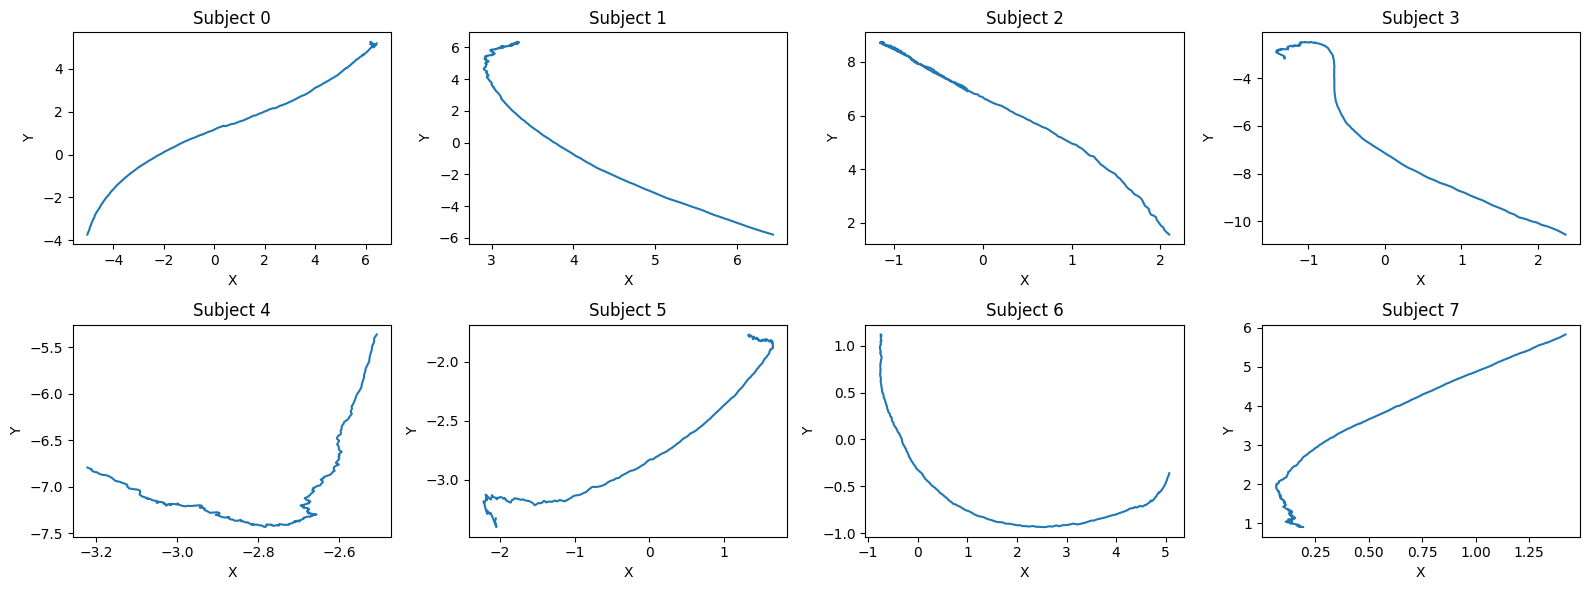

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 6))  # 2 righe, 4 colonne
axes = axes.flatten()  # Rende l'array bidimensionale in un array 1D per iterare facilmente

for i in range(8):
    # Stato iniziale casuale
    z0 = torch.randn(1, latent_size).to(device) # [1, latent_dim]

    # Genera la traiettoria
    with torch.no_grad():
        generated_fixation = sdes[i].generate_fixation(z0, avg_fix_len) # [avg_fix_len, 2]

    # Visualizzazione
    ax = axes[i]
    ax.plot(generated_fixation[:, 0], generated_fixation[:, 1])
    ax.set_title("Subject " + str(i))

plt.tight_layout()
plt.savefig("generated_fixations.png")